# Local specialisation Arloesiadur data pilot: Data loading and analysis notebook


## Load data
Raw data:

* IDBR Nomis data
* APS data
* Input/output data
* ETL

## Industry segmentation

* Extract sector similarity matrices (correlation between sectors)
* Combine similarity matrices (after normalisation).
* Identify industrial clusters.

Outputs
* Collections of SIC codes for an analysis of industrial specialisation in the UK


## Economic complexity analysis
* Use method of reflections to quantify economic complexity of UK Local Authorities

## Prediction analysis
* Train ML model on patterns of specialisation change


## 0. Preamble

In [3]:
#Magic
% matplotlib inline

#Imports
#Directory management
import os
import sys

#Data download
from urllib.request import urlretrieve
from urllib.request import urlopen
import requests
import ratelim
import xlrd
import itertools

#Data processing
import datetime
import re

#Data analysis
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
#Directories

#Set current dir
cur_dir = os.getcwd()

#Create input data folder, intermediate output folder and output folder

if 'input_data' not in os.listdir():
    os.mkdir('input_data')
if 'intermediate_outputs' not in os.listdir():
    os.mkdir('intermediate_outputs')
if 'outputs' not in os.listdir():
    os.mkdir('outputs')


In [5]:
#Functions (move them up here as you write them)
def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

def extract_sic_code_aps(x):
    '''
    Input: an integer coding for a SIC
    Output: A string with the right code. If the integer <10000 append it to a zero. Otherwise, remove its last zero
    '''
    
    if x <10000:
        out = "sic_"+'0'+ str(int(x/10))
    else:
        out = "sic_"+str(int(x/10))
    
    return(out)

def process_single_num(x):
    '''
    input: A code in the input output tables
    output: A well formated value for processing
    '''
    
    if (len(x)==1):
        out = '0'+x.strip()
        return(out)
    if (len(x)>2):
        out = re.sub("\\.","",x.strip())
        return(out)
    else:
        return(x)
    
    

## 1. ETL

### Nomis data
#### Tasks
* extract the data and generate location quotients by area; generate correlation matrix.

In [6]:
#Data downloaded from Nomis using the query builder. 
#TODO: Construct an analogous API call (limit is 25000 cells so it requires several calls)

idbr_sic_lad = pd.read_csv("data_input/idbr_sic_lad.csv",skiprows=8,header=0)

#Some observations: 
#Rows are LADs, Columns are business counts by 4-digit SICs.
#This contains info for all local authority district/4-digit SIC combinations.
#All numbers are rounded to the closest 5.
#We can do a rowSum to get total number of businesses in an area, but this will be (slightly) distorted by rounding and 
    #removal of sectors with little activity. TODO: Download business count at a more aggregate level (e.g. broad industry groups)
#There are some comments to remove at the end of the table.

#Drop them.
idbr_sic_lad = idbr_sic_lad.ix[:405,:]

In [7]:
#Get business totals by city and by sector

#City
city_biz_counts = pd.concat([idbr_sic_lad.ix[:,0],idbr_sic_lad.ix[:,2:].sum(axis=1)],axis=1)
print(city_biz_counts.sort(columns=0,ascending=False)[:10])

#Write out city business counts to use in other normalisations
city_biz_counts.to_csv("intermediate_outputs/city_biz_counts.csv",index=False)

print("There are {x} areas with no activity".format(x=sum([x==0 for x in city_biz_counts[0]])))

#Sector
sector_counts = pd.DataFrame(idbr_sic_lad.ix[:,2:].sum(axis=0))
print(sector_counts.sort(columns=0,ascending=False)[:10])
print(" ")
print("There are {x} sectors with no activity".format(x=sum([x==0 for x in sector_counts[0]])))


    local authority: district / unitary (prior to April 2015)        0
202                                        Westminster         45935.0
129                                         Birmingham         29480.0
70                                               Leeds         26215.0
189                                             Camden         25545.0
292                                           Cornwall         22840.0
300                                          Wiltshire         21495.0
204                                             Barnet         20790.0
14                                       Cheshire East         18420.0
196                                            Lambeth         17530.0
359                                 Edinburgh, City of         17210.0
There are 0 areas with no activity
                                                           0
7022 : Business and other management consultanc...  153425.0
6202 : Computer consultancy activities               90560.0
8

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


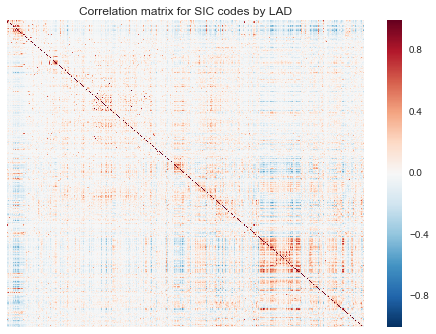

In [15]:
#Produce location quotients: for each column: divide the column by its sum, and then divide this 
    #by the ratio of the rowsum in the colsum of the rowSum.    
#Local shares to divide each column by.
local_shares = city_biz_counts[0]/np.sum(city_biz_counts[0])    

#This matrix could be used to measure diversity in Hidalgo's framework.
sic_lqs = idbr_sic_lad.ix[:,2:].apply(lambda x: (x/x.sum()/local_shares),axis=0)
sic_lqs.fillna(value=0,inplace=True)

#Correlation matrix
#Remove sectors with no activity
some_act = [x>0 for x in sector_counts[0]]

sic_lqs_active = sic_lqs.iloc[:,some_act]

sic_cor_mat = sic_lqs_active.corr()
sns.heatmap(sic_cor_mat,xticklabels=False,yticklabels=False)

plt.title("Correlation matrix for SIC codes by LAD")
plt.savefig("outputs/sic_cor_mat.pdf")


In [7]:
#TODO: I will need to tidy up the data. In particular, extract 4-digit SIC indices from the long names. This is one
#to do later, once I have extracted all the datasets and decided what convention to go for.

### APS data

### Tasks
* Load the data
* Extract SOC counts by 4-digit SIC and generate location quotients (share of occ in sector compared to share of population).
* Produce correlation matrix


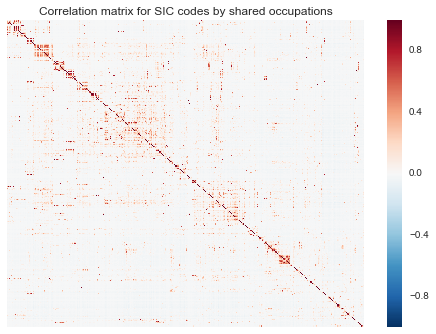

In [40]:
#The APS database we have used in this analysis is a big, micro-dataset.
#We just load a processed version
aps_cor_mat = pd.read_csv("data_input/aps_correlation_matrix.csv")


sns.heatmap(aps_cor_mat,xticklabels=False,yticklabels=False)

plt.title("Correlation matrix for SIC codes by shared occupations")
plt.savefig("outputs/aps_cor_mat.pdf")

### Input / Output data
#### Tasks
* Download data
* Load. This should be easy.

In [11]:
#Url from the ONS website
url = "http://www.ons.gov.uk/file?uri=/economy/nationalaccounts/supplyandusetables/datasets/inputoutputsupplyandusetables/current/webtables105bb16tables14final.xls"

#Extract data
resp = requests.get(url)
with open('data_input/i_ot.xls', 'wb') as output:
    output.write(resp.content)

#Load into a dataframe
io_df = pd.read_excel('data_input/i_ot.xls',sheetname='Table 2 - Int Con 2014',skiprows=3)
#io_df.fillna(value=0,inplace=True)

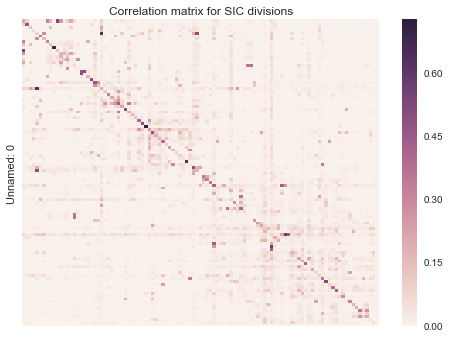

In [12]:
#Convert into matrix.
#Convert SIC digits into index
io_df2 = io_df.set_index(io_df.columns[0],drop=True)

#Drop string columns
io_df2 = io_df2.ix[1:,1:]

#Drop last columns and rows (totals)
io_df2 = io_df2.iloc[:,['Unnamed' not in x for x in io_df2.columns]]
io_df2 = io_df2.iloc[[str(i)!='nan' for i in io_df2.index],:]

#Plot
#Change type
io_df2 = io_df2.astype(float)
#io_df.fillna(value=0,inplace=True)

#We will use the same approach as Delgado: for each pair of industries, select the maximum share of 
    #consumption in each other's output.
io_df2_shares = io_df2.apply(lambda x: x/x.sum())

io_df_final = pd.DataFrame(index=io_df2_shares.index,columns=io_df2_shares.columns)
io_df_final.fillna(value=0,inplace=True)

#Do it with this loop.
for i in range(0,len(io_df2_shares)-1):
    for j in range(0,len(io_df2_shares)-1):
        v1 = io_df2_shares.ix[i,j]
        v2 = io_df2_shares.ix[j,i]
        
        val = np.max([v1,v2])
        
        io_df_final.ix[i,j]=val
        io_df_final.ix[j,i]=val
    
    

sns.heatmap(io_df_final,xticklabels=False,yticklabels=False)
plt.title('Correlation matrix for SIC divisions')

## 2. Merging
#### Tasks:
* We need three matrices with the same dimensions and codes. We will focus on the intersection of sic_cor_mat (the matrix based on co-locations, and aps_cor_mat, the matrix based on shared occupations.

In [16]:
#Change indices and columns in SIC and APS matrices
idbr_sim_mat = sic_cor_mat.copy()
aps_sim_mat = aps_cor_mat.copy()


idbr_sim_mat.index = [x[:4] for x in idbr_sim_mat.index]
idbr_sim_mat.columns = [x[:4] for x in idbr_sim_mat.columns]

aps_sim_mat.index = [x.split("_")[1] for x in aps_sim_mat.index]
aps_sim_mat.columns = [x.split("_")[1] for x in aps_sim_mat.columns]

#Subset them by the shared SIC codes
shared_sics = sorted(list(set(aps_sim_mat.index) & set(idbr_sim_mat.index)))

#Subset both matrices
idbr_sim_mat = idbr_sim_mat[shared_sics]
idbr_sim_mat = idbr_sim_mat.iloc[[x in shared_sics for x in idbr_sim_mat.index],:]

aps_sim_mat = aps_sim_mat[shared_sics]
aps_sim_mat = aps_sim_mat.iloc[[x in shared_sics for x in aps_sim_mat.index],:]

In [17]:
#We also need to process the third matrix (based on trade)
#Strategy: melt the matrix, merge it with the shared indices, and pivot.
#Unfortunately, this requires tidying up the columns in the io table as well.

sics_for_io = pd.DataFrame({'sics':shared_sics})
#sics_for_io


In [18]:
#Read the edited version of code names
codes_cleaned = pd.read_csv("intermediate_outputs/divisions.csv")

#Melt to facilitate merging
io_df3 = io_df_final.copy()

io_df3.fillna(value=0,inplace=True)
io_df3.index = codes_cleaned.ix[:,1]
io_df3.index.rename('code',inplace=True)

io_df3.reset_index(drop=False,inplace=True)
melted_io = pd.melt(io_df3, id_vars ='code')

#Transform into a list
process_list = [[x,y,z] for x,y,z in zip(melted_io['code'],
                                         melted_io['variable'],
                                         melted_io['value'])]


In [19]:
#Need to pre-process all the info in the input-output before merging

processed_list =[]

for i in range(0,len(process_list)):
    #Input the code
    code_input = process_list[i]
    code_var = code_input[0]
    #print(code_var)
    
    #Are there any &s?
    if bool(re.search("&",code_var))==True:
        offspawn = code_var.split("&")
        
        for i in offspawn:
            
            #Are there any -s?
            if bool(re.search("-",i))==True:
                
                #Split by them
                offspawn_2 = i.split("-")
                
                #Recreate numbers in the series by creating a template based on the first number, which we fill
                first_num_template = offspawn_2[0][:-1]
                
                #Filling template
                extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
                #We need to fill the space between both
                int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
                #Get numbers to interpolate with
                interpol = list(range(int_range[0]+1,int_range[1]))
                
                middle_nums = [first_num_template+str(x) for x in interpol]
                
                all_nums = extreme_nums + middle_nums
                for i in all_nums:
                    processed_list.append([process_single_num(i),code_input[1],code_input[2]])
            else:
                processed_list.append([process_single_num(i),code_input[1],code_input[2]])
                    
    elif bool(re.search("-",code_var))==True:
        #Split by them
        offspawn_2 = code_var.split("-")
            
        #Recreate numbers in the series by creating a template based on the first number, which we fill
        first_num_template = offspawn_2[0][:-1]
                
        #Filling template
        extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
        #We need to fill the space between both
        int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
        #Get numbers to interpolate with
        interpol = list(range(int_range[0]+1,int_range[1]))
                
        middle_nums = [first_num_template+str(x) for x in interpol]
                
        all_nums = extreme_nums + middle_nums
        for i in all_nums:
            processed_list.append([process_single_num(i),code_input[1],code_input[2]])
    else:
        processed_list.append([process_single_num(code_var),code_input[1],code_input[2]])

In [22]:
#Repeat the same process for the 'columns' in the melted df.
processed_list_2 = []

for i in range(0,len(processed_list)):
    #Input the code
    code_input = processed_list[i]
    code_var = code_input[1]
    #print(code_var)
    
    #Are there any &s?
    if bool(re.search("&",code_var))==True:
        offspawn = code_var.split("&")
        
        for i in offspawn:
            
            #Are there any -s?
            if bool(re.search("-",i))==True:
                
                #Split by them
                offspawn_2 = i.split("-")
                
                #Recreate numbers in the series by creating a template based on the first number, which we fill
                first_num_template = offspawn_2[0][:-1]
                
                #Filling template
                extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
                #We need to fill the space between both
                int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
                #Get numbers to interpolate with
                interpol = list(range(int_range[0]+1,int_range[1]))
                
                middle_nums = [first_num_template+str(x) for x in interpol]
                
                all_nums = extreme_nums + middle_nums
                for i in all_nums:
                    processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
            else:
                processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
                    
    elif bool(re.search("-",code_var))==True:
        #Split by them
        offspawn_2 = code_var.split("-")
            
        #Recreate numbers in the series by creating a template based on the first number, which we fill
        first_num_template = offspawn_2[0][:-1]
                
        #Filling template
        extreme_nums = [first_num_template+x if n>0 else x for n,x in enumerate(offspawn_2)]
                
        #We need to fill the space between both
        int_range = [int(x.strip()[-1]) for x in extreme_nums]
                
        #Get numbers to interpolate with
        interpol = list(range(int_range[0]+1,int_range[1]))
                
        middle_nums = [first_num_template+str(x) for x in interpol]
                
        all_nums = extreme_nums + middle_nums
        for i in all_nums:
            processed_list_2.append([code_input[0],process_single_num(i),code_input[2]])
    else:
        processed_list_2.append([code_input[0],process_single_num(code_var),code_input[2]])


In [23]:
#Next steps:
#Look for the best match for shared codes in the new, cleaned io codes

#These are the unique codes in the io list
cleaned_io = list(set([x[0] for x in processed_list_2]))

#Use another loop to go through each shared code and find the best match.

sic4_io_best_matches = []

for i in shared_sics:
    #Container
    comps = []
    comps.append(i)
    
    #Logic of the loop: look for matches at different levels of aggregation.
    #Needs to take into account that we lose the leading 0 when turning strings into numbers.
    if i in cleaned_io:
        comps.append(i)
        
    else:
        i_3 = str(int(int(i)/10))
        if len(i_3)<3:
            i_3 = '0'+i_3
            
        if i_3 in cleaned_io:
            comps.append(i_3)
        else:
            i_2 = str(int(int(i_3)/10))
            if len(i_2)<2:
                i_2 = '0'+i_2
            if i_2 in cleaned_io:
                comps.append(i_2)
                
    sic4_io_best_matches.append(comps)

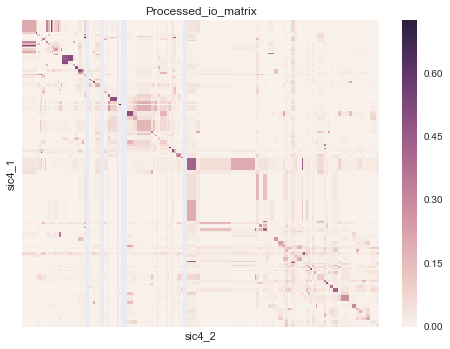

In [25]:
#Now we have the best matches. Process all this to create the io similarity matrix with SIC codes in index + col

#Create melted matrix
sic_4_mat = pd.DataFrame(index=shared_sics,columns=shared_sics)
sic_4_mat.reset_index(drop=False,inplace=True)
sic_4_melt = pd.melt(sic_4_mat,id_vars='index')
sic_4_melt.columns = ['sic4_1','sic4_2','val']

#Create lookup between sic-4 and divisions
sic_div_lookup = pd.DataFrame(sic4_io_best_matches,columns=['sic4','div_match'])

#Merges with the lookup to get the div keys:
sic_4_combs_lookup_1 = pd.merge(sic_4_melt,sic_div_lookup,
                                left_on='sic4_1',right_on='sic4',how='outer')
sic_4_combs_lookup_2 = pd.merge(sic_4_combs_lookup_1,sic_div_lookup,
                              left_on='sic4_2',right_on='sic4',how='outer')

#Create processed list dataframe
div_scores = pd.DataFrame(processed_list_2,columns=['div_1','div_2','value'])

#Merge again
sic_4_io_matrix = pd.merge(sic_4_combs_lookup_2,div_scores,
                          left_on=['div_match_x','div_match_y'],
                          right_on=['div_1','div_2'],
                          how='outer')

#Pivot
io_sim_mat = pd.pivot_table(sic_4_io_matrix,index='sic4_1',columns='sic4_2',values='value')

sns.heatmap(io_sim_mat,xticklabels=False,yticklabels=False)
plt.title("Processed_io_matrix")

In [26]:
#Done!!

In [27]:
#Normalise all the matrices
sim_mats = [idbr_sim_mat,aps_sim_mat,io_sim_mat]
sim_mats_norm = [(x-np.mean(x))/np.std(x) for x in sim_mats]

#How do they correlate with each other?
all_coeffs = pd.concat([pd.melt(sim_mats_norm[0],value_name='cor_idbr'),
                        pd.melt(sim_mats_norm[1],value_name='cor_aps'),
                        pd.melt(sim_mats_norm[2],value_name='cor_io')],axis=1)[['cor_idbr','cor_aps','cor_io']]

all_coeffs.describe()

/usr/local/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,cor_idbr,cor_aps,cor_io
count,2.948490e+05,2.948490e+05,2.650380e+05
mean,3.699124e-18,6.000534e-18,-2.345795e-16
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.755313e+00,-1.366150e+00,-1.115837e+00
25%,-5.102882e-01,-3.153993e-01,NaN
50%,-1.439374e-01,-2.004277e-01,NaN
75%,3.858043e-01,-7.312236e-02,NaN
max,1.880715e+01,2.317412e+01,2.239786e+01


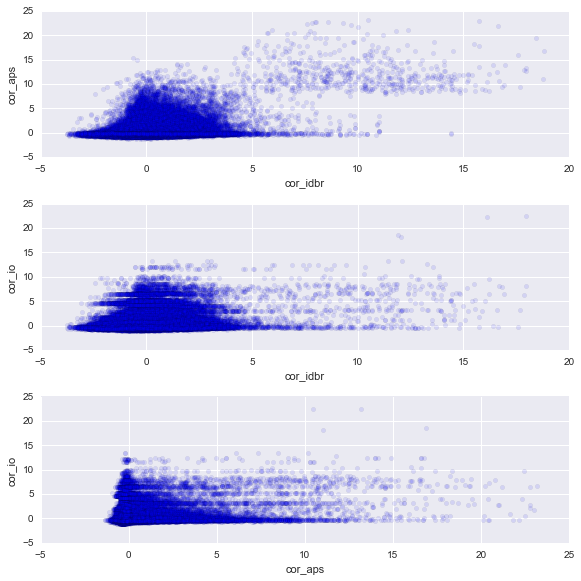

,cor_idbr,cor_aps,cor_io
cor_idbr,1.000000,0.370879,0.200204
cor_aps,0.370879,1.000000,0.271129
cor_io,0.200204,0.271129,1.000000


In [28]:
#Plot their scatters
f,ax = plt.subplots(figsize=(8,8))

plt.subplot(3,1,1)
plt.scatter(all_coeffs['cor_idbr'],all_coeffs['cor_aps'],alpha=0.1)
plt.xlabel('cor_idbr')
plt.ylabel('cor_aps')

plt.subplot(3,1,2)
plt.scatter(all_coeffs['cor_idbr'],all_coeffs['cor_io'],alpha=0.1)
plt.xlabel('cor_idbr')
plt.ylabel('cor_io')

plt.subplot(3,1,3)
plt.scatter(all_coeffs['cor_aps'],all_coeffs['cor_io'],alpha=0.1)
plt.xlabel('cor_aps')
plt.ylabel('cor_io')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

all_coeffs.corr()

In [29]:
#Estimate the mean ignoring nans (there are some in io)
sim_mat_mean = np.nanmean(np.array([np.array(i) for i in sim_mats_norm]),axis=0)

sim_mat_mean_idbr_aps = np.nanmean(np.array([np.array(i) for i in sim_mats_norm[:1]]),axis=0)

sim_mat_mean_idbr_io = np.nanmean(np.array([np.array(i) for i in [sim_mats_norm[x] for x in [0,2]]]),axis=0)

sim_mat_mean_aps_io = np.nanmean(np.array([np.array(i) for i in sim_mats_norm[1:]]),axis=0)


## 3. Clustering

### Tasks

* Write functions that fit Kmeans and Agglomerative clusters to different dfs using K (number of clusters) as parameters
* This generates lists of clusters
* Write functions that evaluate the performance on clusters based on similarities inside and between in all the similarity matrices that we have created.
* Generate a subset of clusters, and write functions that evaluate their robustness.
* That's it.

In [30]:
#Imports
from sklearn.cluster import KMeans, AgglomerativeClustering

In [31]:
#Create idbr and aps dfs for processing

#IDBR
#Create df with rows = SICs and cols = LADs
idbr_clust_proc = sic_lqs_active.T.reset_index(drop=False)

#Create the 4-digit SIC code for masking
idbr_clust_proc.sic_4=[x.split(" :")[0] for x in idbr_clust_proc['index']]

#Mask to obtain the selected df
idbr_clust_df = idbr_clust_proc.ix[[x in shared_sics for x in idbr_clust_proc.sic_4],1:]

#APS
#Same process
aps_clust_proc = aps_lqs.T.reset_index(drop=False)
aps_clust_proc.sic_4 = [x.split("_")[1] for x in aps_clust_proc['industry']]
aps_clust_df = aps_clust_proc.ix[[x in shared_sics for x in aps_clust_proc.sic_4],1:]


#Create sic-descr lookup
sic_descr_lookup = pd.DataFrame([x.split(" :")[0] for x in idbr_sic_lad.columns[2:]],
                                [x.split(":")[1].strip() for x in idbr_sic_lad.columns[2:]]).reset_index(drop=False)
sic_descr_lookup.columns=['descr','sic_4']

sic_selected_lookup = sic_descr_lookup.ix[[x in shared_sics for x in sic_descr_lookup.sic_4],:].reset_index(drop=True)

In [35]:
def extract_kmeans(df,k,n_init=20):
    '''
    input: a df with n samples (SIC codes) vs m features (LQs)
    Output: a df with 3 columns: 4 digit code, code description & cluster allocation based on the kmeans algorithm
    
    '''
    #Initialise and fit the model
    kmeans = KMeans(n_clusters=k,n_init=n_init)
    kmeans.fit(np.array(df))
    
    #Generate outputs
    output = pd.DataFrame({'sic_4':shared_sics,
                           'descr': sic_selected_lookup.descr,
                           'clust':list(kmeans.labels_)})
    return(output)

def extract_agglom(df,k):
    '''
    input: a df with distances, and the number of clusters to extract
    Output: a df with 3 columns: 4 digit code, code description & cluster allocation based on ward variance 
        #minimisation algorithm
    '''
    #Fill NAs (only an issue with the input-output similarity matrix)
    if type(df)==np.ndarray:
        df = pd.DataFrame(df)
    df.fillna(value=0,inplace=True)
    
    #Initialise and fit model
    agg = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean',linkage='ward')
    agg.fit(np.array(df))
    
    #Produce output
    output = pd.DataFrame({'sic_4':shared_sics,
                           'descr': sic_selected_lookup.descr,
                           'clust':list(agg.labels_)})
    return(output)

def get_validation_score(clustering_output):
    '''
    input: a clustering output (df with SICs labelled with clusters obtained from a kmeans or extract agglom function)
    returns: a df where, for the cluster, we have:
        #Cluster validation scores (mean similarity inside the cluster vs mean similarities outside)
        #Industry validation scores (mean similarity of an industry inside the cluster vs. other industries)
        
    '''
    #print("running")
    #Input clustering output
    in_df = clustering_output
    
    #Group them by cluster categoru
    grouped_sics = in_df.groupby('clust')['sic_4'].apply(lambda x: list(x))
    
    #Apply the function to get validation scores to all similarity matrices and clusters configurations (C)
   
    #This will return 3 lists with two elements each.
        #0 is the cluster validation score for that matr
        #1 is the industry validation score for that matr

    all_scores = [extract_scores(grouped_sics,x) for x in sim_mats_norm]
        
    #Extract cluster scores and industry scores, 
    cluster_scores = pd.concat([pd.DataFrame(x[0]).mean(axis=0) for x in all_scores],axis=1)
    cluster_scores.columns=['c_'+x for x in ['idbr','occ','io']]

    industry_scores = pd.concat([pd.DataFrame(x[1]).mean(axis=0) for x in all_scores],axis=1)
    industry_scores.columns=['i_'+x for x in ['idbr','occ','io']]

    cluster_scores['c_mean'] = cluster_scores.mean(axis=1)
    industry_scores['i_mean'] = industry_scores.mean(axis=1)

    final_scores = pd.concat([cluster_scores,industry_scores],axis=1)
    final_scores['c_i_mean'] = final_scores[['c_mean','i_mean']].mean(axis=1)
    
    return(final_scores)

def extract_scores(sics,sim):
    '''
    input: sics - a series grouped by clusters and a similarity matrix to extract validation scores with
    output: Mean cluster validation scores and mean industry validation scores
    
    '''
    
    #Create container cluster score list
    cluster_score = []
    industry_score = []
    
    
    #For each index (cluster) in the grouped object
    for i in sics.index:
        #Extract the object (cluster configuration)
        sics_in_cluster = sics[i]
        
        #It doesn't make any sense to consider clusters with a single SIC code. They are not analysed here.
        if (len(sics_in_cluster)>1):
        
            #Subset the matrix to get the relevant cells (inside the cluster)
            in_cluster_mat = np.array(
                sim.ix[[x in sics_in_cluster for x in sim.index],[x in sics_in_cluster for x in sim.columns]])

            #Fill the diagonal with nans (it doesn't make sense to consider an industry's similarity to itself)
            np.fill_diagonal(in_cluster_mat,np.nan)

            #Calculate mean similarity (here we are focusing on only one of the triangles of the similarity matrix)
            wcr = np.nanmean(in_cluster_mat[np.tril_indices_from(in_cluster_mat)])
            
            #Calculate intra-cluster industry similarity.
            #We get this for each sic by summing over rows in the int matrix.
            
            wcr_ind_mat = list(pd.DataFrame(in_cluster_mat).mean(axis=1))
            

            #Create empty object to insert similarities with other clusters
            bcr_distr = []
            
            #And same thing for the industries
            bcr_ind_distr=[]

            #Loop over each of the other clusters
            for j in sics.index:
                #If we are considering a different cluster
                if i!=j & len(sics[j])>1:
                    
                    #Extract codes
                    sics_out_cluster = sics[j]
                    
                    #Create matrix where rows = industries in cluster i, and columns = industries in cluster j
                    out_cluster_mat = np.array(
                        sim.ix[[x in sics_in_cluster for x in sim.index],[x in sics_out_cluster for x in sim.columns]])   

                    #Calculate mean distances and append to bcr
                    bcr = np.mean(out_cluster_mat)
                    
                    #Put it in bcr dist
                    bcr_distr.append(bcr)
                    
                    #Then calculate the mean similarities for each sic in the initial cluster (by summing over cols)
                    bcr_ind_sim = out_cluster_mat.sum(axis=1)
                    bcr_ind_distr.append(bcr_ind_sim)
                    
            
            #Create empty dict for scores
            scs = {'95pct':np.nan,
                  'mean':np.nan}
            
            #How many times is the within cluster similarity higher than mean cluster similarity and 
                #95 pct cluster similarity?
            scs['95pct']=1 if wcr > pd.Series(bcr_distr).quantile(0.95) else 0
            scs['mean']=1 if wcr > np.nanmean(bcr_distr) else 0

            cluster_score.append(scs)
            
            
            #Here we want to compare each element in wcr_ind_mat (mean similarities between each
                #industry in a cluster and the others) vs its mean similarity with elements in other clusters,
                #and the 95pct of that similarity
            bcr_ind_df = pd.DataFrame(bcr_ind_distr)
            mean_bcr_ind = list(bcr_ind_df.mean(axis=1))
            
            pc95_bcr_ind = list(bcr_ind_df.apply(lambda x: x.quantile(0.95),axis=1))
            
            #scs_inds = [[x,y,z] for x,y,z in zip(wcr_ind_mat,mean_bcr_ind,pc95_bcr_ind)]
            
            scs_inds = [{'mean':1 if x>m else 0,
                        '95pct':1 if x> pct else 0} for x,m,pct in zip(wcr_ind_mat,mean_bcr_ind,pc95_bcr_ind)]
            
            
            industry_score.append(scs_inds)
    
    #Flatten the list
    industry_score_flat = [x for el in industry_score for x in el]
    return([cluster_score,industry_score_flat])      

In [34]:
#Dealing with a bug in pandas 
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [36]:
#Generate outputs

#All mean matrices
mean_mats = [sim_mat_mean,sim_mat_mean_idbr_aps,sim_mat_mean_idbr_io,sim_mat_mean_aps_io]

agglom_k_combos = sim_mats_norm + mean_mats
kmeans_k_combos = [idbr_clust_df,aps_clust_df]

#Extraction
agglom_scores = [get_validation_score(extract_agglom(x[0],x[1])) for x in list(
        itertools.product(agglom_k_combos,list(range(30,65,2))))]
kmeans_scores = [get_validation_score(extract_kmeans(x[0],x[1])) for x in list(
        itertools.product(kmeans_k_combos,list(range(30,65,2))))]

In [32]:
#Extract scores from the containers and put them in a dataframe.

validation_scores_df = pd.DataFrame(x.ix['95pct',:] for x in agglom_scores+kmeans_scores).reset_index(drop=True)

#Assign names
agg_mat_names = ['idbr_sim','aps_sim','io_sim','mat_mean','idbr_aps_mean','idbr_io_mean','aps_io_mean']
kmeans_mat_names = ['idbr_clust_df','aps_clust_df']

validation_scores_df['v_names'] = [x[0] + "_" + str(x[1]) for x in list(
        itertools.product(agg_mat_names,list(range(30,65,2))))+
                                    list(itertools.product(kmeans_mat_names,list(range(30,65,2))))]

#Additional info about the findings
validation_scores_df['algo'] = ['k_means' if 'df' in x else 'ward' for x in validation_scores_df['v_names']]
validation_scores_df['k'] = [x.split("_")[-1] for x in validation_scores_df['v_names']]
validation_scores_df['type'] = ["_".join(x.split("_")[:-1]) for x in validation_scores_df['v_names']]

#Sort and get the top 10
validation_scores_df.sort(columns='c_i_mean',ascending=False)[1:15]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,c_idbr,c_occ,c_io,c_mean,i_idbr,i_occ,i_io,i_mean,c_i_mean,v_names,algo,k,type
71,0.906250,1.000000,0.687500,0.864583,0.281768,0.572744,0.707182,0.520565,0.692574,mat_mean_64,ward,64,mat_mean
69,0.883333,1.000000,0.733333,0.872222,0.276243,0.548803,0.701657,0.508901,0.690562,mat_mean_60,ward,60,mat_mean
68,0.896552,1.000000,0.724138,0.873563,0.261510,0.558011,0.688766,0.502762,0.688163,mat_mean_58,ward,58,mat_mean
70,0.903226,1.000000,0.677419,0.860215,0.281768,0.558011,0.694291,0.511357,0.685786,mat_mean_62,ward,62,mat_mean
65,0.903846,0.980769,0.711538,0.865385,0.272560,0.545120,0.679558,0.499079,0.682232,mat_mean_52,ward,52,mat_mean
66,0.907407,0.962963,0.722222,0.864198,0.285451,0.534070,0.675875,0.498465,0.681331,mat_mean_54,ward,54,mat_mean
59,0.875000,0.975000,0.850000,0.900000,0.236140,0.501027,0.611910,0.449692,0.674846,mat_mean_40,ward,40,mat_mean
117,0.791667,1.000000,0.812500,0.868056,0.207392,0.523614,0.681725,0.470910,0.669483,aps_io_mean_48,ward,48,aps_io_mean
58,0.868421,0.973684,0.842105,0.894737,0.237006,0.474012,0.617464,0.442827,0.668782,mat_mean_38,ward,38,mat_mean
119,0.788462,1.000000,0.788462,0.858974,0.194175,0.565049,0.671845,0.477023,0.667999,aps_io_mean_52,ward,52,aps_io_mean


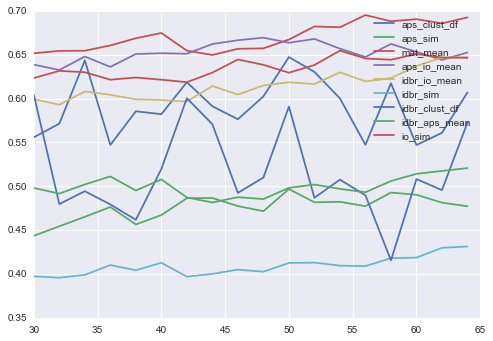

In [33]:
g = validation_scores_df.groupby('type')
for i in g.groups.keys():
    data = g.get_group(i)
    plt.plot(data.k,data['c_i_mean'],label=i)
    plt.legend()

In [34]:
extract_agglom(sim_mat_mean,k=56).sort(columns='clust').to_csv("intermediate_outputs/clusters.csv")
extract_kmeans(aps_clust_df,k=30).sort(columns='clust').to_csv("intermediate_outputs/clusters_2.csv")

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [35]:
#Extract overlap scores
def extract_overlap_scores(threshold):
    '''
    input: A threshold for the number of clusters to focus on
    output: returns a df with overlap scores for each of the matrices.
    '''
    
    #Sort and subset the DF to get the similarity matrices we're interested in
    top_vs = validation_scores_df.sort(
        columns='c_i_mean',ascending=False).reset_index(drop=False).ix[:threshold,['k','type']]

    #NB need tore-write this to also include aps_cluster_df (outputs of Kmeans). Those get high
    #validation scores but not for the right reasons i.e. they have lots of singleton clusters excluded
    #from the validation scoring process (when we do if len(sics_in_cluster)>1). 
    #Need to re-write the validating score function to deal with this,
    #e.g. by not doing means of scores but sums divided by total number of clusters.
    
    #This is a lookup to get the matrices.
    type_mat_lookup ={
    "mat_mean":sim_mat_mean,
    "aps_io_mean":sim_mat_mean_aps_io
    }
    
    #Create combinations of matrices and ks
    my_combs = [[m,type_mat_lookup[m],k] for m,k in zip(top_vs.type,top_vs.k) if m not in 
                ["aps_clust_df","idbr_clust_df"]]

    combinations = list(itertools.combinations(my_combs,2))

    #For each of the pairs, calculate the overlap score (based on the cluster with the greatest overlap)
    results=[]
    
    for i in combinations:
        #if i[0][0]!=i[1][0]:
        #print("running")
        
        #Extract clusters
        c1 = extract_agglom(i[0][1],int(i[0][2])).groupby('clust')['sic_4'].apply(lambda x: list(x))
        c2 = extract_agglom(i[1][1],int(i[1][2])).groupby('clust')['sic_4'].apply(lambda x: list(x))
        
        
        c_max_overlap = []
            #For each of the clusters, find the cluster with the maximum overlap, and estimate the overlap score
        for j in c1.index:
            
            #Overlaps with all other clusters
            overlaps = [len(list(set(c1[j]) & set(c2[n]))) for n in c2.index]
            
            #Index for maximum overlap
            max_overlap = overlaps.index(max(overlaps))
            
            #Overlap score
            overlap = 100*(len(list(set(c1[j]) & set(c2[max_overlap])))/math.sqrt(
                    (len(set(c1[j]))*len(set(c2[max_overlap])))))
            #Add to the scores
            c_max_overlap.append(overlap)
        
        #Append the results (with info about what the matrix os)
        results.append([i[0][0]+"_"+str(i[0][2]),
                        i[1][0]+"_"+str(i[1][2]),
                        np.mean(c_max_overlap)])
        
    #Calculate the average overlap scores for each similarity matrix-k combo...in a hacky way.
    results = pd.DataFrame(results)
    
    results.columns= ['m1','m2','val']
    results_store=[]
    
    #Subset the matrix for values equal to each of the unique matrix - k combo and get the mean
    for i in set(list(results.m1.values)+list(results.m2.values)):
        mat_ind = [m1 == i or m2==i for m1,m2 in zip(results.m1,results.m2)]
        mat_subs = results.ix[mat_ind,'val'].mean()
        results_store.append([i,mat_subs])
    #Extract
    return(pd.DataFrame(results_store,columns=['mat','mean_overlap_score']))
    

In [36]:
results = extract_overlap_scores(10)
results.sort(columns='mean_overlap_score',ascending=False)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,mat,mean_overlap_score
5,mat_mean_56,90.136713
0,mat_mean_58,89.076891
1,mat_mean_54,88.547743
10,mat_mean_60,88.357970
9,mat_mean_52,87.758378
3,mat_mean_62,87.737636
8,mat_mean_64,86.210665
2,mat_mean_40,80.557796
6,mat_mean_38,78.540826
7,aps_io_mean_52,77.913075


In [219]:
#Scores look quite high at th top. I'd go for mat mean 64, 56 or 58.
#Next steps: 
#Get the SIC codes through extract_agglom, consolidate in the initial idbr matrix and re-calculate LQs per LAD.

#Focus on mat_means_64
extract_agglom(sim_mat_mean,k=64).sort(columns='clust').to_csv("intermediate_outputs/clusters_64.csv")

#We relabel the data offline and load (nb flags are clusters with potential issues (funnies, similarity to
    #other clusters etc)) This should eventually be revised.
ind_clusters_labelled = pd.read_csv("intermediate_outputs/clusters_64_labelled.csv",
                                    encoding = "ISO-8859-1")

ind_clusters_labelled.head()

#And now need to convert the sic codes into strings with a leading zero if they are smaller than 1. 
#TODO refactor, I am repeating myself

ind_clusters_labelled['sic_4_string'] = [
    "0"+str(x) if len(str(x))<4 else str(x) for x in ind_clusters_labelled.sic_4]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


## 4. Process SIC4 data into new clusters

* Merge clusters with idbr matrix, re-calculate LQs.
* Stretch (if needed) - extract 2011 data and analyse changes.
* Perform a Hidalgo-style analysis: diversity vs ubiquity, create map of the 'industry space'.



In [220]:
#Merge.

#Get the df
idbr_clusters_process = idbr_sic_lad.copy()
idbr_clusters_process.rename(columns={'local authority: district / unitary (prior to April 2015)':'lad_name',
                                     'mnemonic':'lad_code'},inplace=True)

#Melt and create sic_4 variable to merg with clusters
idbr_clusters_process2 = pd.melt(idbr_clusters_process,id_vars=['lad_name','lad_code'])
idbr_clusters_process2['sic_4_l'] = idbr_clusters_process2['variable'].apply(lambda x:
                                                                          x.split(":")[0].strip())

idbr_clusters_merged = pd.merge(idbr_clusters_process2,ind_clusters_labelled,
                               left_on='sic_4_l',right_on='sic_4_string',how='inner')

In [221]:
dis = list(set(idbr_clusters_process2.sic_4_l) - set(ind_clusters_labelled.sic_4_string))
print("{dis} have dropped out from the analysis - why?".format(dis=len(dis)))

73 have dropped out from the analysis - why?


In [222]:
missing_sic4s = idbr_clusters_process2.ix[[
        x in dis for x in idbr_clusters_process2.sic_4_l],['variable','value','sic_4_l']].groupby(
    "sic_4_l")['value'].sum()

#In most cases they simply have no activity.
missing_sic4s.sort_values(ascending=False)[1:10]

#But there are 3 missing from there. What are they? Values missing from aps? Todo: check this.

sic_4_l
4624    75.0
0144     5.0
9900     0.0
1042     0.0
1062     0.0
1073     0.0
1081     0.0
1102     0.0
1104     0.0
Name: value, dtype: float64

In [223]:
#Pivot the merged df
#This aggregates levels of activity over clusters
idbr_clusters_counts = pd.pivot_table(idbr_clusters_merged,
                        index='lad_name',columns=['label'],values='value',aggfunc=np.sum,fill_value=0)
idbr_clusters_counts.reset_index(drop=False,inplace=True)

#Create a DF with LQs

area_shares = idbr_clusters_counts.sum(axis=1)/np.sum(idbr_clusters_counts.sum(axis=1))

idbr_clusters_lqs = pd.concat([idbr_clusters_counts['lad_name'],
                              idbr_clusters_counts.ix[:,1:].apply(lambda x: (x/x.sum())/area_shares,axis=0)],
                              axis=1)

In [224]:
#Extract the top 10 areas per sector.
#Removing areas with low levels of activity.

def extract_sector_tops(sector,threshold=15,mass=0.5):
    '''
    This function takes a sector name and returns the top thres (default=10) clusters above
        #a minimum level of industry mass (default=0.5)
    
    '''
    
    #identify areas above min mass in the idbr_cluster_counts df
    #Value
    min_act = idbr_clusters_counts[sector].quantile(mass)
    min_act_mask = idbr_clusters_counts[sector]>min_act
    
    #identify high lads
    high_lads = list(idbr_clusters_counts['lad_name'][min_act_mask])
    
    #Subset the lq by these
    lq_subset = idbr_clusters_lqs.ix[[x in high_lads for x in idbr_clusters_lqs.lad_name],
                                     ['lad_name',sector]]
    
    tops = list(lq_subset.sort(columns=sector,ascending=False)[:threshold]['lad_name'][:threshold])
    
    output = {'sector':sector,
             'top_areas':[tops]}
    return(output)


def extract_area_tops(area,threshold=10,mass=0.33):
    '''
    This function takes a lad name and returns its top thres sectors (as long as they are
        #above a minimum level of local mass)
    '''
    
    #Get area min value
    idbr_indexed = idbr_clusters_counts.set_index('lad_name')
    area_act = idbr_indexed.loc[area]
    min_act = area_act.quantile(mass)
    
    #Identify sectors above the min_act threshold
    tops = list(area_act.index[[x > min_act for x in area_act]])
    
    #Subset the LQ df by these sectors/area
    
    area_df = idbr_clusters_lqs.ix[idbr_clusters_lqs.lad_name==area,
                                 [x in tops for x in idbr_clusters_lqs.columns]].T
    
    area_df.columns=['lq']
    area_df.reset_index(drop=False,inplace=True)
    
    tops = list(area_df.sort(columns='lq',ascending=False)[:threshold]['index'])
    
    output = {'area':area,
             'top_areas':[tops]}
    return(output)

In [225]:
top_per_sector = pd.concat([pd.DataFrame(extract_sector_tops(x,threshold=15)) for x in idbr_clusters_lqs.columns[1:]])
top_per_area = pd.concat([pd.DataFrame(extract_area_tops(x)) for x in idbr_clusters_lqs.lad_name])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [226]:
top_per_area.to_csv("intermediate_outputs/area_esp.csv")

In [227]:
idbr_clusters_lqs.to_csv("intermediate_outputs/industry_clusters.csv",index=False)

## 5. Diversity analysis

**Tasks**
* Produce the specialisation matrix
* Produce the economic complexity metrix
* Product the industry space index



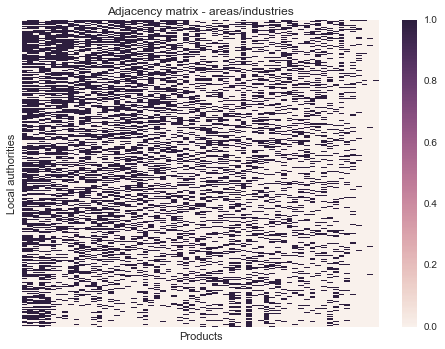

In [228]:
#Specialisation matrix:
location_industry_adjacency =  idbr_clusters_lqs.ix[:,1:].applymap(lambda x: 1 if x>1 else 0)

#Order by columns and rows
sorted_sectors = list(location_industry_adjacency.sum().sort_values(ascending=False).index)
sorted_areas = list(location_industry_adjacency.sum(axis=1).sort_values(ascending=False).index)

#Rejigged matrix:
location_industry_adjacency_ordered =location_industry_adjacency.ix[sorted_areas,sorted_sectors]

sns.heatmap(location_industry_adjacency_ordered,xticklabels=False,yticklabels=False)

plt.title("Adjacency matrix - areas/industries")
plt.xlabel("Products")
plt.ylabel("Local authorities")
plt.savefig("outputs/adj_mat_area_ind.pdf")

In [229]:
#Most 'diverse' areas
div_lads = idbr_clusters_lqs['lad_name'][sorted_areas]
print(", ".join(div_lads[1:10]))

#Least ubiquitous sectors
#It's picking up lots of natural resources
print(", ".join(sorted_sectors[:10]))

Kingston upon Hull, City of, County Durham, Bradford, Basildon, Fife, Bristol, City of, Stockport, Test Valley, Nottingham
construction, services_automotive, manufacture_machinery, services_agriculture_rural, manufacture_furniture, services_waste_recycling, services_repair_machinery, manufacture_plastic, services_cleaning_facilities, services_consumer_retail


In [230]:
#Now we need to take this to the next level

In [231]:
def eci_algorithm_simplified(adj_matrix,iterations=3):
    '''
    This algorithm replicates the work in HH. It takes a matrix and a number of
    iterations to apply the method of reflections. 
    The output is len=number of iterations. Each element contains a list with two elements:
        Element one is a vector of values for each area.
        Element 1 is a vector of values for each industry
    
    -For areas, if the value of the iteration is even (0,2,4...), the vector captures the 
    level of diversification of the area. After the first iteration, this is weighted by the diversity
    of other areas with the same industries.
    
    If the value of the iteration is odd (1,3,5), the vector captures the ubiquity of its industries.
    
    -For industries, if the value of the iteration is even (0,2,4,...) the vector captures the level of
    ubiquity of each industry. After the first iteration, this is weighted by the ubiquity of other areas with
    the same industries.
    
    If the value of the iteration is odd (1,3,5) the vector captures the diversity of the areas that specialise
    in this industry.
    
    '''
    #Initial diversity vector
    div_vect = adj_matrix.sum(axis=1)
    
    #Initial diversity vector
    ubi_vect = adj_matrix.sum()
    
    #Iterator
    
    #Create containers
    kc = [list(div_vect)]
    kp = [list(ubi_vect)]
    
    #Initialise
    i = 0
    
    while i<=iterations:
        #print(i)
        eci_cont=[]
        epi_cont=[]
        
        for country in adj_matrix.index:
            eci=(1/div_vect[country])*np.sum(adj_matrix.ix[country,:]*kp[i])
            eci_cont.append(eci)
        
        for product in adj_matrix.columns:
            epi = (1/ubi_vect[product])*np.sum(adj_matrix.ix[:,product]*kc[i])
            epi_cont.append(epi)
        i +=1
        kc.append(eci_cont)
        kp.append(epi_cont)
     
    #print(kp[0].index)
    out = [[pd.Series(x,index=idbr_clusters_lqs['lad_name']),
           pd.Series(y,index=ubi_vect.index)] for x,y in zip(kc,kp)]
    return(out)
    

In [232]:
reflections_output = eci_algorithm_simplified(location_industry_adjacency,iterations=16)

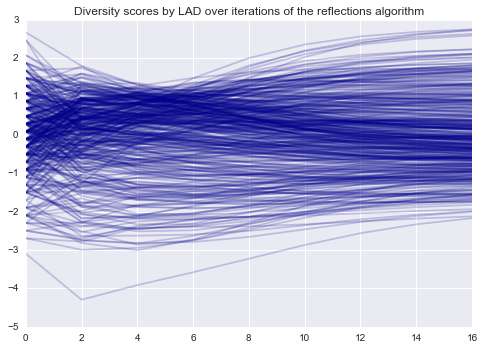

In [233]:
diversity_scores = pd.concat([pd.DataFrame(x[0],columns=[str(num)]) 
                              for num,x in enumerate(reflections_output) if num % 2==0],axis=1)
diversity_scores_norm = diversity_scores.apply(lambda x: scipy.stats.zscore(x))

for i in diversity_scores_norm.index:
    data = diversity_scores_norm.ix[i,:]
    plt.plot(data,alpha=0.2,color='darkblue')
    
plt.title("Diversity scores by LAD over iterations of the reflections algorithm")


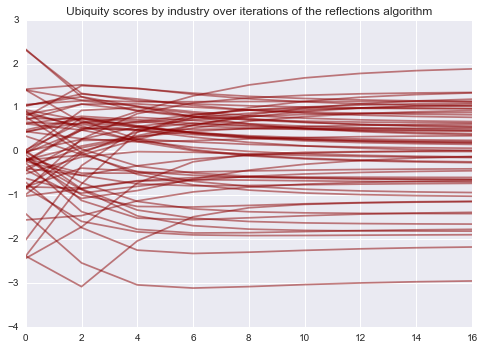

In [234]:
ubiquity_scores = pd.concat([pd.DataFrame(x[1],columns=[str(num)]) 
                              for num,x in enumerate(reflections_output) if num % 2==0],axis=1)
ubiquity_scores_norm = ubiquity_scores.apply(lambda x: scipy.stats.zscore(x))

for i in ubiquity_scores_norm.index:
    data = ubiquity_scores_norm.ix[i,:]
    plt.plot(data,alpha=0.5,color='darkred')
    
plt.title("Ubiquity scores by industry over iterations of the reflections algorithm")

In [235]:
#What are the most and least diversified areas?
div_out = reflections_output[16][0].sort_values(ascending=False)

print("10 most diversified LADs are {areas} and the 10 least diversified areas are {areas_2}".
      format(areas=", ".join(div_out[:10].index),areas_2=", ".join(div_out[-10:].index)))

print(" ")

#What industries are the most ubiquitous?
ubi_out = reflections_output[16][1].sort_values(ascending=False)

print("10 most ubiquitous industries are {inds} and the 10 least ubiquitous industries are {inds_2}".
      format(inds=", ".join(ubi_out[:10].index),inds_2=", ".join(ubi_out[-10:].index)))

10 most diversified LADs are St Albans, Lambeth, Wandsworth, Richmond upon Thames, Elmbridge, Southwark, Bromley, Barnet, Chiltern, Merton and the 10 least diversified areas are Ballymoney, Magherafelt, Strabane, Larne, Coleraine, Omagh, Torridge, Fermanagh, Limavady, Moyle
 
10 most ubiquitous industries are primary_livestock, primary_mining, primary_fishing, services_leisure, manufacture_machinery, manufacture_furniture, primary_farming, primary_forestry, services_agriculture_rural, services_urban_transport and the 10 least ubiquitous industries are services_travelling_tourism, manufacture_light_misc, services_publishing, services_business_support, services_human_resources, services_kibs, services_computing, services_finance_real_state, services_creative, services_creative_content


## 7. Extra analysis for the blog

In [249]:
#How many of the clusters have components in different sections.
#Plan: group by clust, create a value count table with the first two numbers of the sic_4 string. How many
#of them contain sic codes from more than 2 divisions?

def get_prop_in_top_division(sic_strings):
    '''
    Input: a vector of 4-digit SIC codes; we will extract the first two strings, and check what proportion is
    #in the top one. After, we can do averages, or count how many clusters contain sic-4s in the same divisions.
    
    '''
    
    sic_2s = pd.Series([x[0:2] for x in sic_strings])
    sic_vals = sic_2s.value_counts()/len(sic_2s)
    
    #Outputs
    #Percentage of sic_4s in the top division
    top_perc = sic_vals[0]
    
    #Number of divisions
    div_num = len(sic_vals)
    
    return(pd.DataFrame({'top_div_perc':top_perc,'number_divs':div_num},index=[0]))

In [250]:
cluster_spread_stats = ind_clusters_labelled.groupby('clust')[
    'sic_4_string'].apply(get_prop_in_top_division).reset_index(level=1,drop=True)

In [251]:
perc_several_divs = np.sum(cluster_spread_stats.number_divs>1)/len(cluster_spread_stats)
mean_prop_accounted_by_top_div = cluster_spread_stats.top_div_perc.mean()

print("The percentage of clusters with 4-digit SIC codes from more than 1 division is {x}%".
     format(x=perc_several_divs*100))
print("The average proportion of SICs accounted by the top division in a cluster is {x}%".
     format(x=np.round(mean_prop_accounted_by_top_div,5)*100))


The percentage of clusters with 4-digit SIC codes from more than 1 division is 71.875%
The average proportion of SICs accounted by the top division in a cluster is 71.666%


In [252]:
#Mapping them

#What do we want to do here?
#Create a boxplot of economic complexity by region? 

#Create a scatter of economic performance vs economic complexity (and another only focusing on urban areas)?

#Create a scatter of economic complexity vs referendum results 

In [253]:
#Load Ashe LAUA data
ashe_laua_df = pd.read_csv("../../data/ashe_laua_df.csv")

#Clean variable names
ashe_laua_df.columns = ashe_laua_df.columns.str.lower()
#Identify variables of interest
my_vars = ['geography_name','obs_value']

#Select variables of interest
ashe_laua_selected_df = ashe_laua_df.ix[
    (ashe_laua_df['measures_name']=="Value") & 
    (ashe_laua_df['pay_name']=="Annual pay - gross"),my_vars].reset_index(drop=True)

#Load referendum results
ref_r = pd.read_csv("../../data/ref_result.csv")

#We have some differences in spelling here.
set(ref_r['Area'])-set(ashe_laua_df['geography_name'])

#Need to fix the differences in spelling
lad_lookup = {"City of Edinburgh":"Edinburgh, City of",
             "Isle of Anglesey":"Anglesey",
             "King's Lynn and West Norfolk":"King`s Lynn and West Norfolk",
             "Rhondda Cynon Taf":"Rhondda, Cynon, Taff",
             "Vale of Glamorgan":"The Vale of Glamorgan"}

ref_r['Area'] = [lad_lookup[x] if x in lad_lookup.keys() else x for x in ref_r['Area']]

area_data = pd.merge(ashe_laua_selected_df,ref_r,left_on='geography_name',right_on='Area')

#Create complexity df
compl_scores = pd.DataFrame(div_out,columns=['comp_score']).reset_index(drop=False)
compl_scores_ref = pd.merge(area_data,compl_scores,left_on='geography_name',
                            right_on='lad_name',how='right')

#Missing ones are Northern Ireland
compl_scores_ref.Region.fillna(value='Northern Ireland',inplace=True)

#Create extra variable
compl_scores_ref['is_scotland']= [x =='Scotland' for x in compl_scores_ref['Region']]

#Remove NAs for the standardisation
compl_scores_ref2 = compl_scores_ref.dropna()

#Create variable of interest
compl_scores_ref_norm = pd.concat([compl_scores_ref2[['lad_name','is_scotland','Region']],
                                   compl_scores_ref2[['comp_score','obs_value']].apply(
        lambda x: scipy.stats.zscore(x))],axis=1)
compl_scores_ref_norm['rem_prop'] = compl_scores_ref2['Remain']/compl_scores_ref2['Leave']


compl_scores_ref_norm.ix[:,['comp_score','obs_value','rem_prop']].corr()

,comp_score,obs_value,rem_prop
comp_score,1.000000,0.677182,0.478138
obs_value,0.677182,1.000000,0.482691
rem_prop,0.478138,0.482691,1.000000


In [270]:
compl_scores_ref[['lad_name','Region']].to_csv('../../intermediate_outputs/lad_region_lookup.csv',index=False)

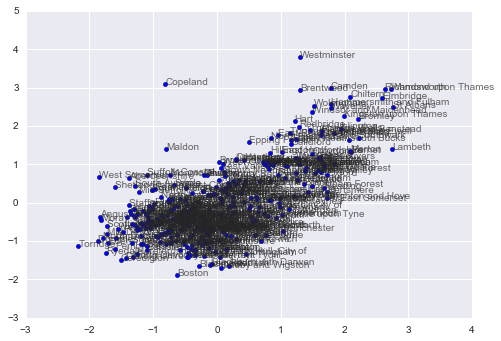

In [254]:
plt.scatter(compl_scores_ref_norm['comp_score'],compl_scores_ref_norm['obs_value'],
           label=[x for x in compl_scores_ref_norm['lad_name']])

labs_etc = [[s,(x,y)] for s,x,y in zip(compl_scores_ref_norm['lad_name'],
                                           compl_scores_ref_norm['comp_score'],
                                           compl_scores_ref_norm['obs_value'])]

for s,xy in labs_etc:
    plt.annotate(s,xy,size='small',alpha=0.7)


In [255]:
#Load rural stuff
rural_lu = pd.read_csv("../../data/Rural_Urban_Classification_2011_of_Local_Authority_Districts_in_England.csv")
#Remove the usual guff
rural_lu = rural_lu.ix[1:326,:]

In [256]:
urban_area = ['Rural' not in x for x in rural_lu.RUC11]

urban_lads = list(rural_lu.ix[urban_area,'LAD11NM'])

compl_df_engl = compl_scores_ref_norm[[
        x not in ['Scotland','Wales'] for x in compl_scores_ref_norm['Region']]]

compl_df_engl['is_urban'] = [True if x in urban_lads else False for x in compl_df_engl['lad_name']]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


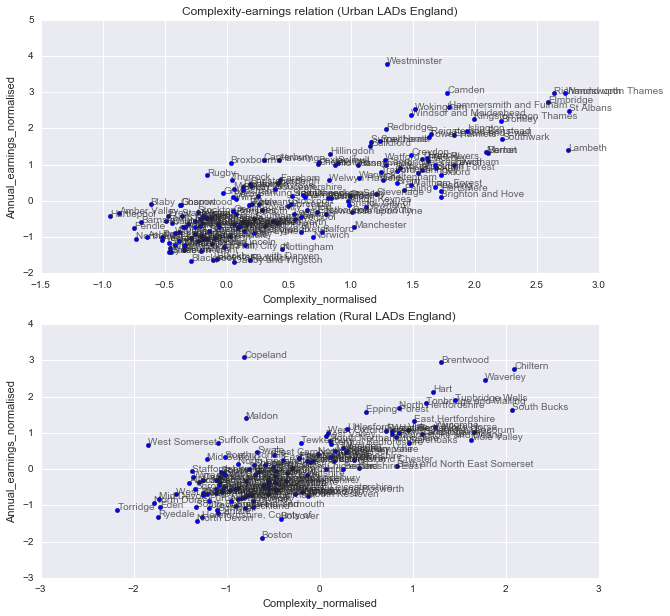

In [257]:
urban_mask = compl_df_engl['is_urban']

fig,ax=plt.subplots(figsize=(10,10))

plt.subplot(2,1,1)
plt.scatter(compl_df_engl.ix[urban_mask,'comp_score'],
            compl_df_engl.ix[urban_mask,'obs_value'],
           label=[x for x in compl_df_engl.ix[urban_mask,'lad_name']])
labs_etc = [[s,(x,y)] for s,x,y in zip(compl_df_engl.ix[urban_mask,'lad_name'],
                                       compl_df_engl.ix[urban_mask,'comp_score'],
                                       compl_df_engl.ix[urban_mask,'obs_value'])]
plt.xlabel('Complexity_normalised')
plt.ylabel('Annual_earnings_normalised')
plt.title('Complexity-earnings relation (Urban LADs England)')
for s,xy in labs_etc:
    plt.annotate(s,xy,size='small',alpha=0.7)
    
plt.subplot(2,1,2)
plt.scatter(compl_df_engl.ix[-urban_mask,'comp_score'],
            compl_df_engl.ix[-urban_mask,'obs_value'],
           label=[x for x in compl_df_engl.ix[-urban_mask,'lad_name']])
labs_etc = [[s,(x,y)] for s,x,y in zip(compl_df_engl.ix[-urban_mask,'lad_name'],
                                       compl_df_engl.ix[-urban_mask,'comp_score'],
                                       compl_df_engl.ix[-urban_mask,'obs_value'])]
for s,xy in labs_etc:
    plt.annotate(s,xy,size='small',alpha=0.7)
    
plt.xlabel('Complexity_normalised')
plt.ylabel('Annual_earnings_normalised')
plt.title('Complexity-earnings relation (Rural LADs England)')

plt.savefig("../../outputs/comp_earnings_scatter.pdf")

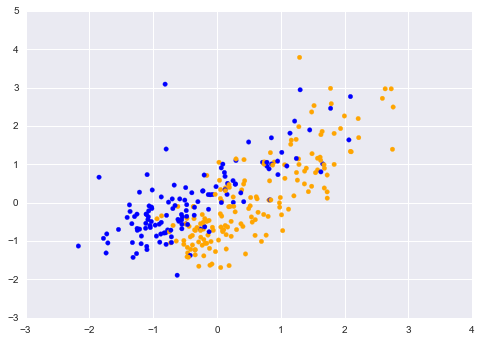

In [258]:
plt.scatter(compl_df_engl.comp_score,
            compl_df_engl.obs_value,
           color=['orange' if x==True else 'blue' for x in urban_mask])

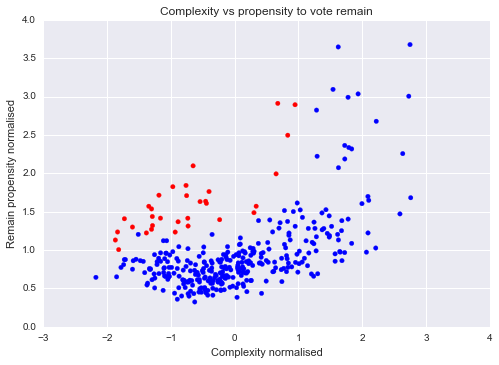

In [259]:
plt.scatter(compl_scores_ref_norm.comp_score,compl_scores_ref_norm.rem_prop,
           color=['red' if x=="Scotland" else 'blue' for x in compl_scores_ref_norm.Region])
plt.xlabel("Complexity normalised")
plt.ylabel("Remain propensity normalised")
plt.title("Complexity vs propensity to vote remain")

plt.savefig("../../outputs/comp_remain_scatter.pdf")

In [260]:
import toyplot.html, toyplot.browser,toyplot.pdf

#Plot the canvas with its dimensions
canvas = toyplot.Canvas(width=600,height=400)

#Plot axes and add their labels
axes = canvas.cartesian(label="Economic complexity and average annual earnings",
                       xlabel="Economic complexity",ylabel="Average annual earnings (normalised)")

label_stye = {"font-size":"8px"}

#Series to plot
x = list(compl_df_engl.comp_score)
y = list(compl_df_engl.obs_value)
z = list([float(x) for x in pd.qcut(compl_df_engl.rem_prop,10,labels=range(10))])
title=list(compl_df_engl.lad_name)

#Create colors based on regions
urban=list(urban_mask)
col = ["darkblue" if i ==True else "orange" for i in urban]

#Style
mstyle={"stroke":toyplot.color.near_black}

#Marking
mark = axes.scatterplot(x,y,size=6,opacity=0.6,mstyle=mstyle,
                        title=title,color=col)
axes.hlines(y=0,style={"stroke-dasharray":"2, 2"})
axes.vlines(x=0,style={"stroke-dasharray":"2, 2"})


#NB we are setting locations of y ticks explicitly to pad the legend and the title
axes.y.ticks.locator = toyplot.locator.Explicit(locations=[0,1,2])

#Legend. NB tis is a tuple with markers for the legend, and their position. The position tuple includes
    #position, inset, width and height
canvas.legend([
        ("Urban", {"shape": "o", "mstyle":{"fill":"darkblue", "stroke": toyplot.color.near_black,
                                              "opacity":0.6}}),
        ("Rural", {"shape": "o", "mstyle":{"fill":"orange", "stroke": "black",
                                                      "opacity":0.9}})],
        corner=("top-left", 50,100, 50),
             );

label_style={"font-size":"8px"}
canvas.text(500, 390, "Sources: ONS",style=label_style)

toyplot.pdf.render(canvas,"outputs/scatter_region.pdf")

In [261]:
#Region boxplot
list_to_plot=[]

compl_scores_ref['compl_score_norm'] = scipy.stats.zscore(compl_scores_ref['comp_score'])

grouped_complexities = compl_scores_ref.groupby('Region')['compl_score_norm']
for i in grouped_complexities:
    list_to_plot.append(i)

list_to_plot.sort(key=lambda x: np.median(x[1]),reverse=True)

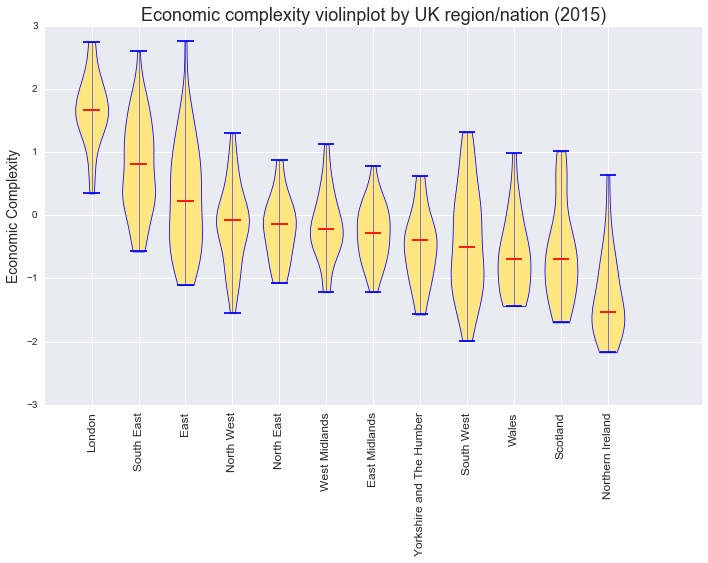

In [262]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)

bp = plt.violinplot([x[1] for x in list_to_plot],showmedians=True,widths=0.7)

plt.xticks(rotation='vertical',size=12)
ax.set_xticks(range(1,13))
ax.set_xticklabels([x[0] for x in list_to_plot])

plt.ylabel("Economic Complexity",size=14)
plt.title("Economic complexity violinplot by UK region/nation (2015)",size=18)

for box in bp['bodies']:
    box.set_linewidth(0.8)
    box.set_edgecolor('blue')
    box.set_facecolor('#ffe680')
    box.set_alpha(1)
    
plt.setp(bp['cmedians'],color='red')
plt.setp(bp['cmaxes'],color='blue')
plt.setp(bp['cmins'],color='blue')
plt.setp(bp['cbars'],color='blue',linewidth=0.5)
                      
                      
#bp.set_xticks([i for i,num in enumerate(list_to_plot)])       
#bp.set_xticklabels([x[0] for x in list_to_plot])   
plt.tight_layout()
    
plt.savefig("outputs/region_complexity_violin_2015.pdf")

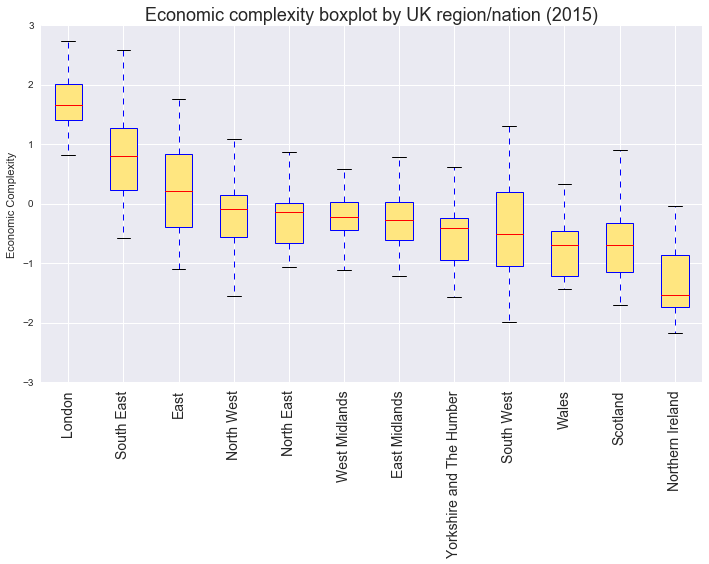

In [263]:
plt.figure(figsize=(10,8))

bp = plt.boxplot([x[1] for x in list_to_plot],labels=[x[0] for x in list_to_plot],patch_artist=True)
plt.xticks(rotation='vertical',size=14)
plt.ylabel("Economic Complexity")
plt.title("Economic complexity boxplot by UK region/nation (2015)",size=18)

for box in bp['boxes']:
    box.set_facecolor('#ffe680')
plt.tight_layout()
    
plt.savefig("outputs/region_complexity_2015.pdf")

In [264]:
#How did they vote in the European referendum - a simple contingency table?
compl_scores_ref['complex_area'] = [True if x > compl_scores_ref.compl_score_norm.quantile(q=0.75) else False for 
                               x in compl_scores_ref.compl_score_norm]

compl_scores_ref['remained'] = [True if x > 50 else False for 
                               x in compl_scores_ref.Pct_Remain]

remain_complex_ct = pd.crosstab(compl_scores_ref.complex_area,compl_scores_ref.remained)
remain_complex_ct.apply(lambda x: 100*x/x.sum(),axis=1)

remained,False,True
complex_area,,
False,83.223684,16.776316
True,35.294118,64.705882


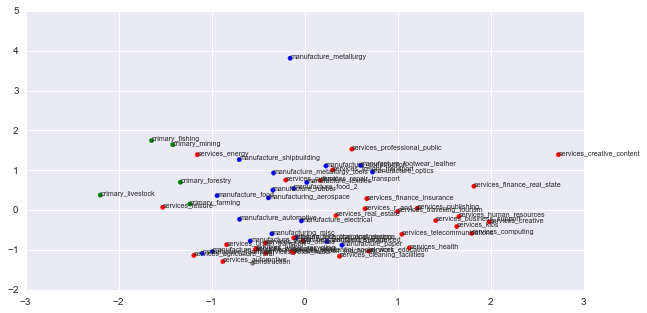

In [265]:


color_lookup = {'manufacturing':'blue',
                'manufacture':'blue',
               'primary':'green',
               'services':'red',
               'mining':'brown',
               'construction':'grey',
               'wholesale':'red'}

def get_herfindahl(x):
    '''
    Extract the herfindahl index of a vector (in shares)
    '''
    h = np.sum([val**2 for val in x])
    return(h)

#A look at industry concentration. We drop a couple of industries with very low levels of activity (less than 10
    #areas with any businesses)
sector_activity = idbr_clusters_counts.ix[:,1:].applymap(lambda x: x>0).sum(axis=0)
sectors_to_exclude = sector_activity.index[sector_activity<10]

#Create modified idbr cluster counts df
cluster_counts_selected = idbr_clusters_counts.ix[[x not in sectors_to_exclude for x in 
                                                  idbr_clusters_counts.index],
                                                  [x not in sectors_to_exclude for x in
                                                  idbr_clusters_counts.columns]]

#I will need to create and sort the shares
industry_area_shares=cluster_counts_selected.ix[:,1:]/cluster_counts_selected.ix[:,1:].sum(axis=0)
industry_area_herfs = industry_area_shares.apply(lambda x: get_herfindahl(x))

#Plot this against complexity and color with the color_lookup
industry_compl = reflections_output[15][1]
industry_compl = industry_compl[[x not in sectors_to_exclude for x in industry_compl.index]]

plt.figure(figsize=(10,5))

plt.scatter(
    scipy.stats.zscore(industry_compl),
    scipy.stats.zscore(np.log(industry_area_herfs)),
    color=[color_lookup[x.split("_")[0]] for x in industry_compl.index])

for t,x,y in zip(
    industry_compl.index,
    scipy.stats.zscore(industry_compl),
    scipy.stats.zscore(np.log(industry_area_herfs))):
             
    plt.annotate(t,(x,y),size=7)


In [266]:
#Another plot idea
#Stacked barchart with lads and regions. Color by the complexity of each industry.
#Actions: Create a slice with the share of industrial activity in each location.
#Shuffle the locations by their complexity, and their products also by their complexity.
#Create a gradient that we will use to color each slice.
#Finally, produce the stacked barchart.


#This beastie merges the df with industry shares per sector and sorts them in descending order of complexity
area_profile = pd.merge(pd.concat([idbr_clusters_counts['lad_name'],
                          idbr_clusters_counts.ix[:,1:].apply(lambda x: x/x.sum(),axis=0)],axis=1),
                        div_out.reset_index(drop=False),
                        left_on='lad_name',right_on='lad_name').sort_values(0,ascending=False).ix[:,1:-1]

#Now we want to shuffle the columns to get the more common ones at the end. We get it from the 
#vector extracted from the method of reflections algorithm.
industries_compl_sorted = industry_compl.sort_values(0,ascending=False).index

#We save this data and chart it in R (easier to do stacked bar-charts over there.)
area_profile = area_profile[industries_compl_sorted]
area_profile.to_csv("outputs/area_profiles_for_barchart.csv",index=False)

#Now we want to create the gradient to colour the sectors